In [1]:
using Gadfly
using ColorBrewer
using DataFrames

In [2]:
df = readtable("../data/bigiron_scan_rep_space_0843ef2_clean.csv");

In [3]:
grouped_info = by(df, [:method, :measure, :genetype, :screen, :representation, :bottleneck_representation, :seq_depth, :crisprtype]) do grouped_df
    n = size(grouped_df, 1)
    mean_score = clamp(mean(grouped_df[:score]), 0, 1)
    std_score = std(grouped_df[:score])
    conf_int = 1.96 * std_score./sqrt(n)
    DataFrame(
        std_score = std_score,
        mean_score = mean_score,
        score_max = mean_score + conf_int,
        score_min = mean_score - conf_int,
        n = n
    )
end
rename!(grouped_info, Dict(:representation => :transfection_representation,
:seq_depth => :sequencing_representation))
n_steps = length(unique(grouped_info[:transfection_representation]))
rep_vals = hcat(map(x->round(Int64, x), logspace(0,4,n_steps)), logspace(0, 4, n_steps))
for repcol in [:transfection_representation, :bottleneck_representation]
    arr = zeros(size(grouped_info, 1))
    for i in 1:size(rep_vals, 1)
        arr[grouped_info[repcol] .== rep_vals[i, 1]] = rep_vals[i, 2]
    end
    grouped_info[repcol] = arr
end
head(grouped_info)

,method,measure,genetype,screen,transfection_representation,bottleneck_representation,sequencing_representation,crisprtype,std_score,mean_score,score_max,score_min,n
1,auprc,dec,all,FacsScreen,1.0,1.0,100,CRISPRKO,0.043470723416432176,0.20563026200138995,0.22267078558063136,0.18858973842214855,25
2,auprc,dec,all,FacsScreen,1.0,1.0,100,CRISPRi,0.04783932548258778,0.24397851781227792,0.26273153340145233,0.2252255022231035,25
3,auprc,dec,all,FacsScreen,1.0,1.0,1000,CRISPRKO,0.0474333317760035,0.20009890127806806,0.21869276733426143,0.1815050352218747,25
4,auprc,dec,all,FacsScreen,1.0,1.0,1000,CRISPRi,0.050190619927648915,0.23396747434647344,0.25364219735811183,0.21429275133483508,25
5,auprc,dec,all,FacsScreen,1.0,1.0,10000,CRISPRKO,0.04664512668209851,0.20535413909132033,0.22363902875070296,0.1870692494319377,25
6,auprc,dec,all,FacsScreen,1.0,1.0,10000,CRISPRi,0.05501768275524113,0.2573908092500015,0.27895774089005604,0.235823877609947,25


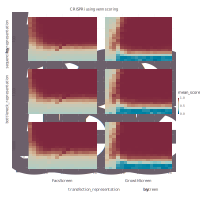

In [4]:
selection = [(:genetype, "all"), (:method, "venn"), (:measure, "incdec"), (:crisprtype, "CRISPRi")]
data = grouped_info[vec(all(hcat([(grouped_info[item[1]] .== item[2]) for item in selection]...), 2)), :];
data[!isfinite(data[:mean_score]), :mean_score] = 0.0

draw(SVG(20cm, 20cm), plot(data, ygroup=:sequencing_representation, xgroup=:screen, x=:transfection_representation, 
y=:bottleneck_representation, color=:mean_score, Geom.subplot_grid(Geom.rectbin,
Coord.cartesian(xmin=0, xmax=4, ymin=0, ymax=4)),
Scale.x_log10, Scale.y_log10, Scale.color_continuous(),
Guide.title("$(unique(data[:crisprtype])[1]) using $(unique(data[:method])[1]) scoring")))

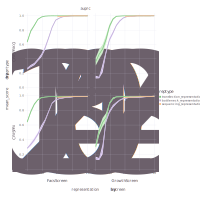

In [5]:
selection = Tuple{Symbol, Any}[
    (:genetype, "all"), 
    (:method, "auprc"), 
    (:measure, "incdec"), 
]
colors = palette("Accent", 4)
reps = [:transfection_representation, :bottleneck_representation, :sequencing_representation]
datas = []
for reptype in combinations(reps, 2)
    push!(selection, (reptype[1], 10^4))
    push!(selection, (reptype[2], 10^4))
    data = grouped_info[vec(all(hcat([(grouped_info[item[1]] .== item[2]) for item in selection]...), 2)), :]
    colname = pop!(setdiff(Set(reps), Set(reptype)))
    data[:reptype] = colname
    data[:representation] = data[colname]
    push!(datas, data)
    pop!(selection)
    pop!(selection)
end
datas = vcat(datas...)
draw(SVG(20cm, 20cm), plot(datas, xgroup=:screen, ygroup=:crisprtype, x=:representation, 
y=:mean_score, ymax=:score_max, ymin=:score_min,
color=:reptype, Scale.x_log10, Geom.subplot_grid(Geom.line, Geom.ribbon, 
Guide.yticks(ticks=collect(0:0.2:1)), Coord.cartesian(ymax=1.0, ymin=0.0)),
Scale.color_discrete_manual(colors[1:3]..., levels=reps),
Theme(line_width=2pt), Guide.title("$(unique(datas[:method])[1])")))